<a href="https://colab.research.google.com/github/Taketo-Muroya/Nowcasting-Project/blob/main/nowcast-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The nowcasting of economic conditions in Japan using ML

## Setting Up

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('drive/MyDrive/Colab Notebooks/Economic-Nowcasting-in-Japan')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install pytrends

In [3]:
# Import packages
import re
import os
import sys
import requests
#import MeCab
#import oseti
#import urllib
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf

from math import sqrt
from bs4 import BeautifulSoup
from pathlib import Path
from subprocess import call
from keras.regularizers import l2
from statsmodels.tsa.seasonal import seasonal_decompose

from nltk.corpus import stopwords as sw       
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
def multivariate_data(dataset, target, start_index, end_index, 
                      history_size, target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    # add current dataset
    indices = range(i-history_size, i+1, step)
    temp = pd.DataFrame(dataset[indices])
    # replace current target to previous one
    temp.iat[history_size, 0] = temp.iat[history_size-1, 0]
    data.append(np.array(temp))

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [5]:
def model_eval_metrics(y_true, y_pred, classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 
                      'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 
                      'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 
                      'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 
                      'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

## Target variable: Indexes of Business Conditions (IBC)

The Index of Business Conditions (IBC) represents monthly economic conditions in Japan. This study uses either coincident index (level) or coincident ann (change from the previouse year: Year-over-Year) as a target variable.

In [6]:
ibc = pd.read_csv('data/ibc_new.csv')
ibc['Coincident ann'] = 100*ibc['Coincident Index'].pct_change(12)
ibc

,time,Coincident Index,Coincident ann
0,Jan-85,79.1,NaN
1,Feb-85,78.8,NaN
2,Mar-85,78.7,NaN
3,Apr-85,79.6,NaN
4,May-85,79.5,NaN
...,...,...,...
438,Jul-21,94.0,16.480793
439,Aug-21,91.0,10.840438
440,Sep-21,88.7,4.722550
441,Oct-21,89.8,1.468927


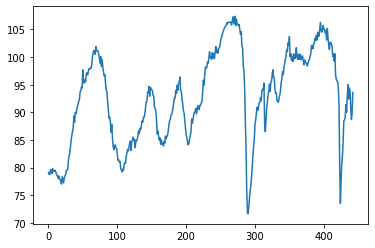

In [7]:
plt.plot(ibc['Coincident Index'])

## Google Trend

Use google trend information as predictors

### Google Trend API

In [8]:
# Import packages
from pytrends.request import TrendReq
plt.rcParams['font.family'] = 'IPAexGothic'

# API Connection
pytrends = TrendReq(hl='ja-JP', tz=360)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys
findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


Correlation of level: -0.89
Correlation of YoY: -0.71


findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


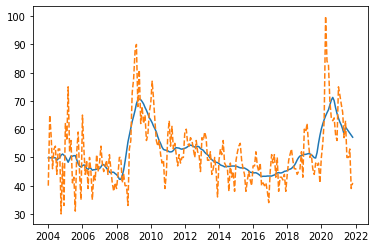

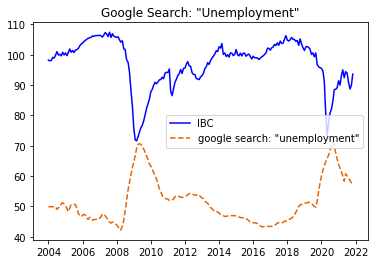

In [9]:
# Set keyword ("失業" = "unemployment")
kw_list = ["失業"]
pytrends.build_payload(kw_list, timeframe='2004-01-01 2021-11-30', geo='JP')
gt1 = pytrends.interest_over_time()
gt1 = gt1.rename(columns = {"失業": "unemployment", "isPartial": "info"})
gt1.to_csv("data/gt1.csv")
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
gt1 = pd.read_csv('data/gt1.csv', index_col=0, date_parser=dateparse, dtype='float')

# Extract trend factor
s1 = seasonal_decompose(gt1.iloc[:,0], extrapolate_trend='freq')
t1 = s1.trend
plt.plot(t1)
plt.plot(gt1.iloc[:,0], linestyle='--')

# Check correlation
level = ibc['Coincident Index'][228:]
level.index = t1.index
cor = level.corr(t1)
print("Correlation of level: {:.2f}".format(cor))

a1 = gt1.iloc[:,0].pct_change(12)
ann = ibc['Coincident ann'][228:]
ann.index = a1.index
cor = ann.corr(a1)
print("Correlation of YoY: {:.2f}".format(cor))

# Plot trend
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(t1.index, ibc['Coincident Index'][228:], linestyle='-', color='b', label='IBC')
ax.plot(t1.index, t1, linestyle='--', color='#e46409', label='google search: "unemployment"')
ax.legend()
plt.title('Google Search: "Unemployment"')
plt.savefig("images/google1.png")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys


Correlation of level: 0.34
Correlation of YoY: 0.14


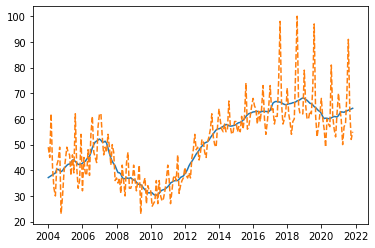

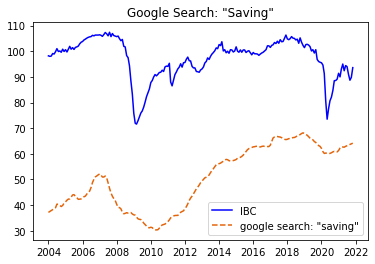

In [10]:
# Set keyword ("貯金" = "saving")
kw_list = ["貯金"]
pytrends.build_payload(kw_list, timeframe='2004-01-01 2021-11-30', geo='JP')
gt2 = pytrends.interest_over_time()
gt2 = gt2.rename(columns = {"貯金": "saving", "isPartial": "info"})
gt2.to_csv("data/gt2.csv")
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
gt2 = pd.read_csv('data/gt2.csv', index_col=0, date_parser=dateparse, dtype='float')

# Extract trend factor
s2 = seasonal_decompose(gt2.iloc[:,0], extrapolate_trend='freq')
t2 = s2.trend
plt.plot(t2)
plt.plot(gt2.iloc[:,0], linestyle='--')

# Check correlation
level = ibc['Coincident Index'][228:]
level.index = t2.index
cor = level.corr(t2)
print("Correlation of level: {:.2f}".format(cor))

a2 = gt2.iloc[:,0].pct_change(12)
ann = ibc['Coincident ann'][228:]
ann.index = a2.index
cor = ann.corr(a2)
print("Correlation of YoY: {:.2f}".format(cor))

# Plot trend
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(t2.index, ibc['Coincident Index'][228:], linestyle='-', color='b', label='IBC')
ax.plot(t2.index, t2, linestyle='--', color='#e46409', label='google search: "saving"')
ax.legend()
plt.title('Google Search: "Saving"')
plt.savefig("images/google2.png")

In [11]:
# Combine google trend (level)
gtrend_l = pd.concat([t1, t2], axis=1)

# Combine google trend (YoY)
gtrend_y = pd.concat([a1, a2], axis=1)
#gtrend_y = gtrend_y.drop(gtrend_y.index[0:12])

### Time series analysis

In [12]:
# Set time series dataset
X = pd.concat([gtrend_l, gtrend_y], axis=1)
y = ibc[228:]
y = y.set_index('time')
X.index = y.index
ts = pd.concat([y, X], axis=1)
ts.to_csv("ts.csv")
dateparse = lambda dates: pd.datetime.strptime(dates, '%b-%y')
ts = pd.read_csv('ts.csv', index_col=0, date_parser=dateparse, dtype='float')

# Split data into training and test set
sp = round(0.8*len(ts))
train = ts[0:sp]
test = ts[sp:]

ts.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


,Coincident Index,Coincident ann,unemployment,saving,unemployment.1,saving.1
time,,,,,,
2021-07-01,94.0,16.480793,60.047009,63.165016,-0.285714,0.228070
2021-08-01,91.0,10.840438,59.327457,63.407877,-0.218750,0.123457
2021-09-01,88.7,4.722550,58.607906,63.650738,-0.158730,0.032787
2021-10-01,89.8,1.468927,57.888355,63.893599,-0.390625,-0.071429
2021-11-01,93.6,5.643341,57.168803,64.136461,-0.293103,0.037736


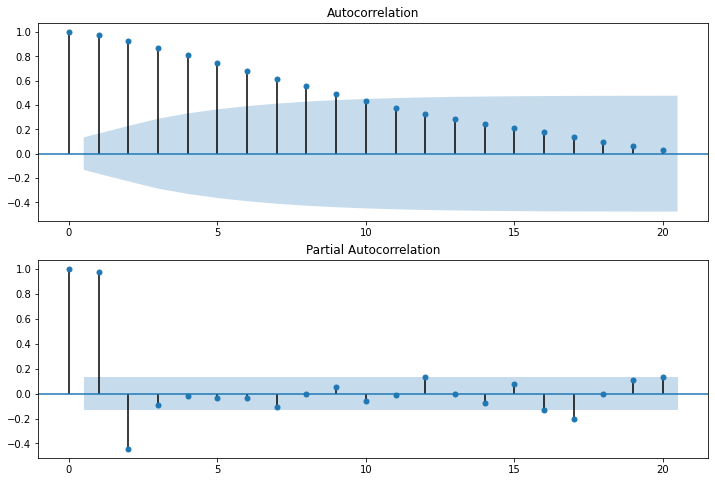

In [13]:
# Check Autocorrelation of IBC
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts['Coincident Index'], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts['Coincident Index'], lags=20, ax=ax2)
plt.savefig("images/autocorrelation.png")

In [14]:
# Unit root test of y (H0: non-stationary)
adf_result = sm.tsa.stattools.adfuller(ts['Coincident Index'])
print("Unit root test (y): {:.2f}".format(adf_result[1])) # p-value

# Take difference of y
diff = ts['Coincident Index'].diff()
diff = diff.dropna()
adf_result = sm.tsa.stattools.adfuller(diff)
print("Unit root test (diff_y): {:.2f}".format(adf_result[1])) # p-value

# Unit root test of X (H0: non-stationary)
adf_result = sm.tsa.stattools.adfuller(ts['unemployment'])
print("Unit root test (X): {:.2f}".format(adf_result[1])) # p-value

# Take difference of X
diff = ts['unemployment'].diff()
diff = diff.dropna()
adf_result = sm.tsa.stattools.adfuller(diff)
print("Unit root test (diff_X): {:.2f}".format(adf_result[1])) # p-value

# Cointegration test (H0: non-cointegration)
coint_result = sm.tsa.stattools.coint(ts['Coincident Index'], ts['unemployment'])
print("Cointegration test (unemployment): {:.2f}".format(coint_result[1])) # p-value
coint_result = sm.tsa.stattools.coint(ts['Coincident Index'], ts['saving'])
print("Cointegration test (saving): {:.2f}".format(coint_result[1])) # p-value

Unit root test (y): 0.07
Unit root test (diff_y): 0.00
Unit root test (X): 0.14
Unit root test (diff_X): 0.01
Cointegration test (unemployment): 0.21
Cointegration test (saving): 0.24


### ARIMA Prediction

In [15]:
# Fit the model
SARIMAX = sm.tsa.SARIMAX(train['Coincident Index'], train.iloc[:,2:4], order=(1,0,0), freq='MS').fit()
print(SARIMAX.summary())

                           Statespace Model Results                           
Dep. Variable:       Coincident Index   No. Observations:                  172
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -295.839
Date:                Mon, 17 Jan 2022   AIC                            599.679
Time:                        09:39:04   BIC                            612.269
Sample:                    01-01-2004   HQIC                           604.787
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
unemployment    -0.8148      0.094     -8.696      0.000      -0.998      -0.631
saving          -0.0196      0.192     -0.102      0.919      -0.396       0.356
ar.L1            1.0000      0.001   1124.33

Test set score: 0.74


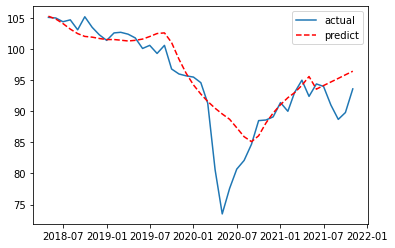

In [16]:
pred = SARIMAX.predict('2018-05-01', '2021-11-01', exog=test.iloc[:,2:4])
plt.plot(test['Coincident Index'], label="actual")
plt.plot(pred, "r", linestyle='--', label="predict")
plt.legend(loc='best')

print("Test set score: {:.2f}".format(r2_score(test['Coincident Index'], pred)))

### Random Forest

Training set score: 0.99
Cross-Validation score: 0.66
Test set score: 0.84


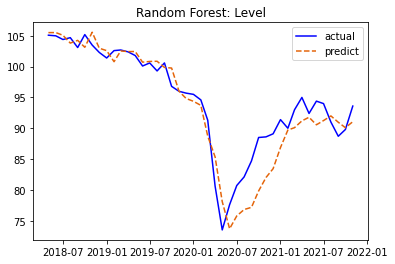

In [17]:
# Set X and y variables
X = ts.iloc[:,2:4]
y = ts['Coincident Index']

# Preprocess for adding AR
X_l = X.drop(X.index[0])
#X_l = X_l.drop(X_l.index[0])
X_l.reset_index(inplace=True, drop=True)

# Generate AR variable
y_l = y.drop(y.index[-1])
#y_l = y_l.drop(y_l.index[-1])
y_l.reset_index(inplace=True, drop=True)

# Add AR into X
X_t = pd.concat([y_l, X_l], axis=1)
y_t = y.drop(y.index[0])
#y_t = y_t.drop(y_t.index[0])
X_t.index = y_t.index

# Split data into training and test set 
sp = round(0.8*len(X_t))
X_train = X_t[0:sp]
X_test = X_t[sp:]
y_train = y_t[0:sp]
y_test = y_t[sp:]

# Fit the model
tm = RandomForestRegressor(n_estimators=1000).fit(X_train, y_train)
#tm.feature_importances_

# Goodness of Fit
print("Training set score: {:.2f}".format(tm.score(X_train, y_train)))
print("Cross-Validation score: {:.2f}".format(
          np.mean(cross_val_score(tm, X_train, y_train, cv=5))))
print("Test set score: {:.2f}".format(tm.score(X_test, y_test)))

# Calculate the prediction
prediction = pd.DataFrame(tm.predict(X_test))
pre = prediction.values.tolist()
act = y_test.values.tolist()
predict = pd.DataFrame(pre, columns=['predict'])
actual = pd.DataFrame(act, columns=['actual'])
com = pd.concat([predict, actual], axis=1)

# Plot the prediction
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(X_test.index, com.actual, linestyle='-', color='b', label='actual')
ax.plot(X_test.index, com.predict, linestyle='--', color='#e46409', label='predict')
ax.legend(loc='best')
ax.set_title('Random Forest: Level')
plt.savefig("images/google_rf.png")

In [18]:
print(tm.feature_importances_)

[0.8067683  0.17642353 0.01680817]


### RNN-LSTM

In [19]:
# set the dataset
features = pd.concat([ts['Coincident Index'], ts.iloc[:,2:4]], axis=1)
features.tail()

,Coincident Index,unemployment,saving
time,,,
2021-07-01,94.0,60.047009,63.165016
2021-08-01,91.0,59.327457,63.407877
2021-09-01,88.7,58.607906,63.650738
2021-10-01,89.8,57.888355,63.893599
2021-11-01,93.6,57.168803,64.136461


In [20]:
# set training percentage
TRAIN_SPLIT = round(0.8*len(features))
print(TRAIN_SPLIT)

# feature scaling
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

172


In [21]:
# create the training and test data

past_history = 3
future_target = 0
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:,0], 0, TRAIN_SPLIT, past_history, future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:,0], TRAIN_SPLIT, None, past_history, future_target, STEP, single_step=True)

In [22]:
pd.DataFrame(dataset).head(7)

,0,1,2
0,0.032678,-0.047423,-0.915926
1,0.006228,-0.046282,-0.883825
2,0.019453,-0.045141,-0.851724
3,0.151705,-0.044000,-0.819624
4,0.125255,-0.042858,-0.787523
5,0.244281,-0.041717,-0.755422
6,0.402984,-0.179888,-0.629711


In [23]:
pd.DataFrame(x_train_single[0])

,0,1,2
0,0.032678,-0.047423,-0.915926
1,0.006228,-0.046282,-0.883825
2,0.019453,-0.045141,-0.851724
3,0.019453,-0.044000,-0.819624


In [24]:
y_train_single[0]

0.15170511389896058

In [25]:
BATCH_SIZE = 32
BUFFER_SIZE = 100

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [26]:
# construct the model

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(8, input_shape=x_train_single.shape[-2:]))
#single_step_model.add(tf.keras.layers.LSTM(8, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
#single_step_model.add(tf.keras.layers.LSTM(8, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
#single_step_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(4)))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss='mae')

In [27]:
# train the model
single_step_history = single_step_model.fit(train_data_single, epochs=20, steps_per_epoch=200, validation_data=val_data_single, validation_steps=50)

Epoch 1/20
200/200 [==============================] - 3s 6ms/step - loss: 0.8291 - val_loss: 0.9536
Epoch 2/20
200/200 [==============================] - 1s 4ms/step - loss: 0.7064 - val_loss: 0.9007
Epoch 3/20
200/200 [==============================] - 1s 4ms/step - loss: 0.6005 - val_loss: 0.8448
Epoch 4/20
200/200 [==============================] - 1s 4ms/step - loss: 0.5232 - val_loss: 0.7837
Epoch 5/20
200/200 [==============================] - 1s 5ms/step - loss: 0.4544 - val_loss: 0.7167
Epoch 6/20
200/200 [==============================] - 1s 5ms/step - loss: 0.3896 - val_loss: 0.6409
Epoch 7/20
200/200 [==============================] - 1s 4ms/step - loss: 0.3340 - val_loss: 0.5601
Epoch 8/20
200/200 [==============================] - 1s 4ms/step - loss: 0.2907 - val_loss: 0.4952
Epoch 9/20
200/200 [==============================] - 1s 5ms/step - loss: 0.2628 - val_loss: 0.4471
Epoch 10/20
200/200 [==============================] - 1s 4ms/step - loss: 0.2457 - val_loss: 0.4149

In [28]:
# evaluate the model
model_eval_metrics(y_val_single, single_step_model.predict(x_val_single), classification="FALSE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0,0,0,0,0.206353,0.454261,0.315218,0.806134


Test set score: 0.81


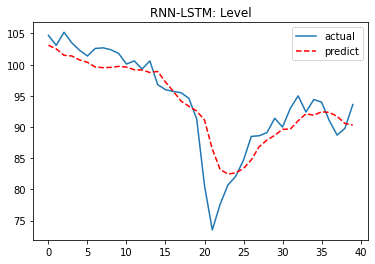

In [29]:
# visualize the result

plt.plot(y_val_single*data_std[0]+data_mean[0], label="actual")
plt.plot(single_step_model.predict(x_val_single)*data_std[0]+data_mean[0], "r", linestyle='--', label="predict")
plt.legend(loc='best')
plt.title('RNN-LSTM: Level')
plt.savefig("images/google_lstm.png")

print("Test set score: {:.2f}".format(r2_score(y_val_single, single_step_model.predict(x_val_single))))

### Weekly Nowcasting

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


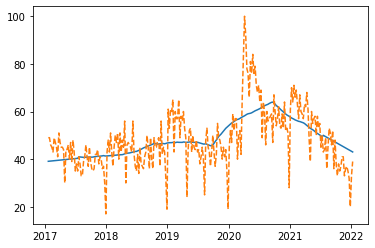

In [30]:
# Get the weekly google trend data (unemployment)
kw_list = ["失業"]
pytrends.build_payload(kw_list, timeframe='today 5-y', geo='JP')
#pytrends.build_payload(kw_list, timeframe='2004-01-01 2020-02-29', geo='JP')
gt3 = pytrends.interest_over_time()
gt3 = gt3.rename(columns = {"失業": "unemployment", "isPartial": "info"})
gt3.to_csv("data/gt3.csv")
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
gt3 = pd.read_csv('data/gt3.csv', index_col=0, date_parser=dateparse, dtype='float')

# Extract trend factor
s3 = seasonal_decompose(gt3.iloc[:,0], extrapolate_trend='freq')
t3 = s3.trend
gtw_u = pd.DataFrame(t3)
gtw_u.to_csv("data/gtw_u.csv")

plt.plot(t3)
plt.plot(gt3.iloc[:,0], linestyle='--')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


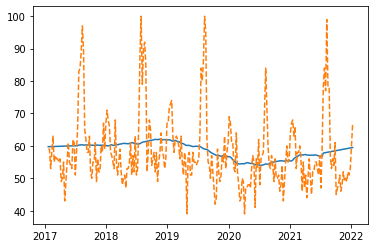

In [31]:
# Get the weekly google trend data (saving)
kw_list = ["貯金"]
pytrends.build_payload(kw_list, timeframe='today 5-y', geo='JP')
#pytrends.build_payload(kw_list, timeframe='2004-01-01 2020-02-29', geo='JP')
gt4 = pytrends.interest_over_time()
gt4 = gt4.rename(columns = {"貯金": "saving", "isPartial": "info"})
gt4.to_csv("data/gt4.csv")
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
gt4 = pd.read_csv('data/gt4.csv', index_col=0, date_parser=dateparse, dtype='float')

# Extract trend factor
s4 = seasonal_decompose(gt4.iloc[:,0], extrapolate_trend='freq')
t4 = s4.trend
gtw_s = pd.DataFrame(t4)
gtw_s.to_csv("data/gtw_s.csv")

plt.plot(t4)
plt.plot(gt4.iloc[:,0], linestyle='--')

In [32]:
# load the weekly ibc data
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
XX = pd.read_csv('data/gtw_all.csv', index_col=0, date_parser=dateparse, dtype='float')

#plt.plot(XX['ibc'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


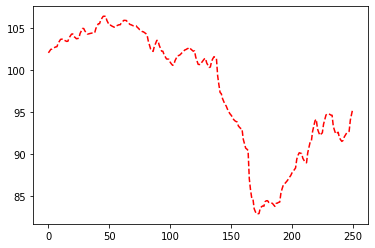

In [33]:
# feature scaling
dataset = XX.iloc[:254,:].values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)
dataset = (dataset-data_mean)/data_std

# create the test data
x_single, y_single = multivariate_data(dataset, dataset[:,0], 0, None, past_history, future_target, STEP, single_step=True)

# save the output
past_estimate = pd.DataFrame(single_step_model.predict(x_single)*data_std[0]+data_mean[0])
plt.plot(past_estimate, "r", linestyle='--', label="predict")

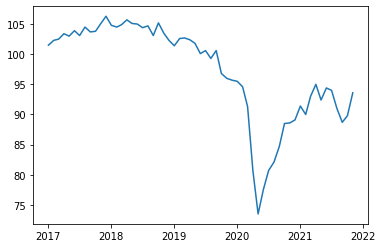

In [34]:
# compare to IBC graph
plt.plot(ts.iloc[156:,0:1])

In [35]:
# nowcast the future IBC
for i in range(254, 260):
  XX.iat[i,0] = float(single_step_model.predict(x_single)[-1]*data_std[0]+data_mean[0])
  #XX.iat[i,0] = XX.iat[i-1,0]
  temp = XX.iloc[:i+1,:]
  print(temp.tail())
  print('-----------------------------------------------')

  # feature scaling
  dataset = temp.values
  data_mean = dataset.mean(axis=0)
  data_std = dataset.std(axis=0)
  dataset = (dataset-data_mean)/data_std
  
  # create the test data
  x_single, y_single = multivariate_data(dataset, dataset[:,0], 0, None, past_history, future_target, STEP, single_step=True)

  XX.iat[i,0] = float(single_step_model.predict(x_single)[-1]*data_std[0]+data_mean[0])
  print(XX.tail(10))
  print('-----------------------------------------------')

# save the output
future_estimate = pd.DataFrame(XX.iloc[254:261,0])

                  ibc  unemployment     saving
date                                          
2021-11-07  93.600000     43.906232  58.875252
2021-11-14  93.600000     43.610624  58.943411
2021-11-21  93.600000     43.315017  59.011570
2021-11-28  93.600000     43.019409  59.079730
2021-12-05  95.422821     42.723801  59.147889
-----------------------------------------------
                  ibc  unemployment     saving
date                                          
2021-11-07  93.600000     43.906232  58.875252
2021-11-14  93.600000     43.610624  58.943411
2021-11-21  93.600000     43.315017  59.011570
2021-11-28  93.600000     43.019409  59.079730
2021-12-05  95.464783     42.723801  59.147889
2021-12-12        NaN     42.428194  59.216049
2021-12-19        NaN     42.132586  59.284208
2021-12-26        NaN     41.836978  59.352367
2022-01-02        NaN     41.541371  59.420527
2022-01-09        NaN     41.245763  59.488686
-----------------------------------------------
           

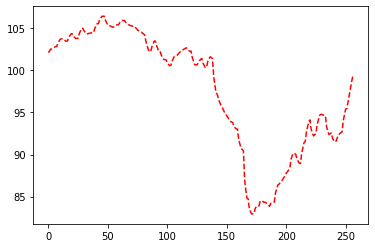

In [36]:
#plt.plot(XX.iloc[52:112,0], "r", linestyle='--', label="predict")
plt.plot(single_step_model.predict(x_single)*data_std[0]+data_mean[0], "r", linestyle='--', label="predict")

In [37]:
new = past_estimate.set_axis(['ibc'], axis='columns')
df_concat = pd.concat([new, future_estimate])
#df_concat
#plt.plot(df_concat, "r", linestyle='--', label="predict")